In [1]:
if __name__ == "__main__":
    from urllib.request import urlretrieve
    base_url = "http://swclass.yonsei.ac.kr:2020/dev/web/1104/"
    urlretrieve(base_url + "15_final.csv", "final.csv")
    urlretrieve(base_url + "15_submit_form.csv", "submit_form.csv")

> A군은 지하철에서 최대한 빨리 앉아가기 위해 좌석에 앉아있는 승객들의 성별, 행동, 외형(옷,소지품등)을 desc열에 기록하였습니다. 또한 A군은 승객들의 나이와 지하철에 타고 있었던 누적 시간을 볼 수 있는 하찮은 초능력이 있어 나이(age)와 누적 탑승시간(time)도 기록할 수 있었습니다. 그리고 분류를 위해 빨리 하차하는 사람은 1.0, 그렇지 않은 사람은 0.0으로 y열에 결과를 기록하였습니다.

+ 주어진 'final.csv'를 이용하여 y값을 예측할 수 있는 result 모델을 생성하고 예측 결과지를 캐글에 제출하세요. 또한 본 노트북 파일은 inclass 15주차에 제출합니다.


In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
# 필요한 라이브러리가 있으면 추가 import 할 수 있습니다.

size = 750 # 학습데이터셋 크기
# 참고: 'final.csv'는 편의상 일괄 데이터처리를 위해 학습 및 테스트 데이터가 통합되어 있습니다.
# df[:size]는 학습셋, df[size:]는 테스트셋이며 df[size:]의 y값은 모두 빈칸으로 되어있습니다.

df = pd.read_csv("final.csv")

df.head()

,no,desc,age,time,y
0,0,"A man talking, with sneakers/backpack/permhair",36.0,00:50,1.0
1,1,"A woman thinking, with permhair/highheels/skir...",49.0,00:27,1.0
2,2,"A man listening, with necktie/sneakers/glasses...",46.0,00:33,0.0
3,3,"A man watching, with backpack/beard/sneakers",38.0,00:36,1.0
4,4,"A woman thinking, with cap/makeup/permhair",29.0,00:39,1.0


In [3]:
df.tail()

,no,desc,age,time,y
995,995,"A man listening, with permhair/backpack",36.0,00:20,NaN
996,996,"A man talking, with sneakers/necktie/cap/permh...",35.0,00:31,NaN
997,997,"A woman watching, with makeup/backpack/skirts",NaN,01:10,NaN
998,998,"A woman listening, with necklace/backpack/skirts",53.0,01:02,NaN
999,999,"A woman watching, with skirts/glasses/backpack...",41.0,00:32,NaN


+ 표 크기 및 자료형 확인

In [4]:
print(df.shape)
print(df.dtypes)

(1000, 5)
no        int64
desc     object
age     float64
time     object
y       float64
dtype: object


+ 데이터를 준비합니다
  + 인코딩
  + 결측값
  + 기타 필요한 처리

In [5]:
# 예시 처리
df1 = df[:size]['age'].fillna(df[:size]['age'].mean())
df2 = df[size:]['age'].fillna(df[size:]['age'].mean())
df_age = pd.concat([df1, df2],axis=0)
df['age'] = df_age

def time2sec(x):
  x = x.split(':')
  val = int(x[0]) * 60 + int(x[1])
  return float(val)


def get_gender(x):
  x = x.split(',')[0].split(' ')

  if x[1] == 'man':
    return 0
  else:
    return 1


state_dict, state_index = {}, 0
def get_state(x):
  global state_dict, state_index
  x = x.split(',')[0].split(' ')

  if x[2] in state_dict:
    return state_dict[x[2]]
  else:
    state_dict[x[2]] = state_index
    state_index += 1
    return state_dict[x[2]]


def split_outfit(x):
  return len(x.split(',')[1].split('/'))


outfit_dict, outfit_index = {}, 0
def get_outfit(x):
  global outfit_dict, outfit_index
  x = x.split(',')[1].split('/')
  if 'with' in x[0]:
    x[0] = x[0].strip().split('with ')[0]

  outfits = []
  for outfit in x:
    if outfit in outfit_dict:
      if outfit_dict[outfit] != 0:
        outfits.append(outfit_dict[outfit])
    else:
      outfit_dict[outfit] = outfit_index
      outfit_index += 1
      if outfit_dict[outfit] != 0:
        outfits.append(outfit_dict[outfit])
  return outfits



desc = df['desc']
gender = desc.apply(get_gender)
state = desc.apply(get_state)

df['time'] = df['time'].apply(time2sec)
df['gender'] = gender
df['state'] = state

max_outfit_len = split_outfit(max(desc, key=lambda x : split_outfit(x)))

header = []
for i in range(max_outfit_len-1):
  header.append('outfit'+str(i+1))

outfits = pd.DataFrame(desc.apply(get_outfit).to_list())
outfits = outfits.fillna(0)
outfits.columns = header

df = pd.concat([df, outfits], axis=1)

+ 데이터 분석

In [6]:
# 예1)
df[["age", "y"]].groupby("y", as_index=False).size()

,y,size
0,0.0,344
1,1.0,406


In [7]:
# 예2)
df[["age", "y"]].groupby("y", as_index=False).mean()

,y,age
0,0.0,33.732072
1,1.0,43.581816


<ipython-input-8-2e253962ba95>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[["age", "y"]])


<Axes: ylabel='Density'>

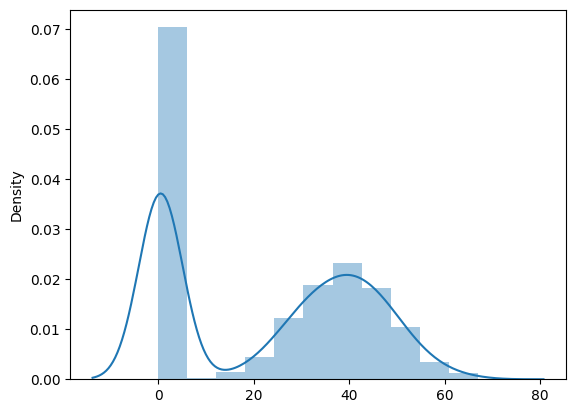

In [8]:
# 예3)
sns.distplot(df[["age", "y"]])

+ 머신러닝에 사용할 컬럼만 남겨둡니다

In [9]:
df = df.drop(columns=['no', 'desc']) # 수정 필요

df.head()

,age,time,y,gender,state,outfit1,outfit2,outfit3,outfit4,outfit5,outfit6
0,36.0,50.0,1.0,0,0,1.0,2.0,0.0,0.0,0.0,0.0
1,49.0,27.0,1.0,1,1,3.0,4.0,5.0,6.0,7.0,1.0
2,46.0,33.0,0.0,0,2,8.0,6.0,1.0,0.0,0.0,0.0
3,38.0,36.0,1.0,0,3,9.0,8.0,0.0,0.0,0.0,0.0
4,29.0,39.0,1.0,1,1,10.0,2.0,0.0,0.0,0.0,0.0


+ 데이터가 준비되면 학습 및 테스트셋을 분할합니다(완성된 코드)

In [10]:
# 완성된 코드
X_train = df[:size].drop(columns=["y"])
y_train = df[:size].y
X_test = df[size:].drop(columns=["y"])
y_test = df[size:].y

+ 여러가지 머신러닝 모델을 생성하고 학습 데이터셋에 대해 교차검증을 수행하며 성능이 좋은 것을 찾는다

In [11]:
clf_list = [SVC(), RandomForestClassifier(random_state=1), AdaBoostClassifier(), GradientBoostingClassifier()] # 수정 필요

for clf in clf_list:
    print(clf.__class__.__name__, end=": ") # 알고리즘명 출력
    print(cross_val_score(clf, X_train, y_train).mean().round(3))

SVC: 0.828
RandomForestClassifier: 0.892
AdaBoostClassifier: 0.904
GradientBoostingClassifier: 0.903


In [12]:
clf = max(clf_list, key=lambda x: cross_val_score(x, X_train, y_train).mean().round(3))

+ 가장 결과가 잘 나오는 모델을 result 변수에 생성하고 피팅 & 테스트 데이터 예측

In [13]:
result = clf.fit(X_train, y_train) # 수정 필요

y_pred = result.predict(X_test)

print(y_pred)

[1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1.
 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1.
 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0.
 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1.
 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0.
 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0.
 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0.
 1. 1. 0. 0. 0. 0. 0. 1. 1. 1.]


+ 예측 결과를 파일로 생성 및 다운로드하여 캐글에 제출(완성된 코드)
 + 채점 기준 및 제출방법 등은 아래 링크를 참고하세요

In [14]:
# 답안 양식을 불러온다.
submit_form = pd.read_csv("submit_form.csv")
# 이전 셀에서 생성한 답안
submit_form["y"] = y_pred
# X부분의 학번을 정확히 작성 (추가 정보는 _로 붙일 수 있습니다)
# 예) "2023112345_SVC"
filename = "202X1XXXXX"
# 캐글에 제출할 파일 생성(왼쪽 드라이브 폴더에서 다운로드 하여 제출)
submit_form.to_csv(f"{filename}.csv", index=False)
# 출력된 링크를 클릭하여 제출 방법 등 확인
print("https://www.kaggle.com/t/ad235babc6bd469e81754c807aa82822")

https://www.kaggle.com/t/ad235babc6bd469e81754c807aa82822


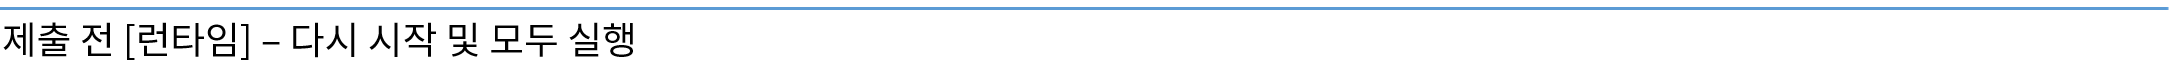